# **Classification of Anti-Semitic Texts**
## **Authors:**                    
*   ### Maxim Subotin - 207695479
*   ### Amiel Cohen - 315196311
---

## **Summary:**
### The goal of this research is to develop a machine learning model capable of accurately classifying antisemitic texts.<br>
### To achieve this objective, we utilize both publicly available labeled datasets and custom datasets composed of Reddit posts and comments that we collected from various subreddits and manually annotated.<br>
### Texts containing at least one of the predefined keywords are labeled as antisemitic, while those that do not are considered benign.<br>
### While this keyword-based approach has its limitations, this research also explores alternative methods for dataset annotation.<br><br>

### The keywords used for classification are as follows:
```
keywords = [
    'jew', 'jews', 'jewess', 'jewish', 'israel', 'isreal', 'israhell', 'idf',
    'zionist', 'zionists', 'zionism', 'zion', 'zio', 'zioist', 'zionazi', 'mossad',
    'mosad', 'palestine', 'palestinian', 'holocaust', 'holohoax', 'hollowhoax', 'shoah', 'shoax',
    'auschwitz', 'treblinka', 'nuremberg', 'kike', 'heeb', 'yid', 'shylock', 'hooknose',
    'goy', 'goyim', 'gentile', 'gentiles', 'bloodlibel', 'zog', 'rothschild', 'circumcision',
    'talmud', 'chosen', 'synagogue', 'occupation', 'occupied'
]
```

---
## **Imports:**

In [1]:
# Imports
import re
import nltk
import torch
import joblib
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm
import xgboost as xgb
from textblob import TextBlob
from collections import Counter
from wordcloud import WordCloud
from sklearn.svm import LinearSVC
from nltk.corpus import stopwords
from sklearn.preprocessing import Normalizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from transformers import AutoTokenizer, AutoModel
from sklearn.neighbors import KNeighborsClassifier
from tensorflow.keras.layers import Dense, Dropout
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Download and get the list of English stop words
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Remove warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## **Loading the Public Datasets:**
### These datasets are the contained tweets gathered and classified such that 1 is anti-semitic content and 0 is benign.<br>
### These datasets are published by institute For the Study of Contemporary Antisemitism (ISCA) at Indiana University Dataset:
*   ### First Dataset (2024): https://zenodo.org/api/records/14448399/files-archive
*   ### Second Dataset (2019): https://zenodo.org/api/records/7932888/files-archive

In [2]:
# Load the dataset
labeled_df1 = pd.read_csv('/content/GoldStandardDataSet.csv', encoding='latin1')
print(f'Dataset Shape: {labeled_df1.shape}')
print(labeled_df1.head(3))

Dataset Shape: (11311, 6)
                    ID       Username                 CreateDate  Biased  \
0  1232258532273090560   amit2nirvana  2020-02-25 10:58:23+00:00       0   
1  1224025761092448257   NinjaAlex420  2020-02-02 17:44:17+00:00       0   
2  1242382710561107969  SevenShepherd  2020-03-24 09:28:15+00:00       0   

  Keyword                                               Text  
0  Israel  The last 24 hours in Israel: https://t.co/0YNw...  
1  Israel  @stranahan KnowMoreNews isn't confident enough...  
2  Israel  "[Even] an heritage unto Israel his servant: f...  


In [3]:
labeled_df2 = pd.read_csv('/content/GoldStandardDataSet2.csv', encoding='latin1')
print(f'Dataset Shape: {labeled_df2.shape}')
print(labeled_df2.head(3))

Dataset Shape: (6941, 6)
               TweetID      Username  \
0  1228740093357092865  Celtic_Films   
1  1239547900012589056     zariths__   
2  1216559517887954945  kelownascott   

                                                Text  \
0  AIPAC should be registered as a foreign agent ...   
1  RT @qiss0rkid: go to israel pls , we don't nee...   
2  The world, including Canada, has given Israel ...   

                  CreateDate  Biased Keyword  
0  2020-02-15 17:57:21+00:00       1  Israel  
1  2020-03-16 13:43:43+00:00       1  Israel  
2  2020-01-13 03:16:06+00:00       1  Israel  


### Rename the columns to have better and simpler names for both datasets

In [4]:
# Ensure the datasets have same column names in the same order
labeled_df1 = labeled_df1.rename(columns={'Biased': 'Label'})
labeled_df2 = labeled_df2.rename(columns={'TweetID': 'ID', 'Biased': 'Label'})
labeled_df2 = labeled_df2[['ID', 'Username', 'CreateDate', 'Label', 'Keyword', 'Text']]

labeled_df1 = labeled_df1.rename(columns={'Biased': 'Label'})
labeled_df2 = labeled_df2.rename(columns={'TweetID': 'ID', 'Biased': 'Label'})

# Print the datasets
print(labeled_df1.head(3))
print('\n----------------------------------------\n')
print(labeled_df2.head(3))

                    ID       Username                 CreateDate  Label  \
0  1232258532273090560   amit2nirvana  2020-02-25 10:58:23+00:00      0   
1  1224025761092448257   NinjaAlex420  2020-02-02 17:44:17+00:00      0   
2  1242382710561107969  SevenShepherd  2020-03-24 09:28:15+00:00      0   

  Keyword                                               Text  
0  Israel  The last 24 hours in Israel: https://t.co/0YNw...  
1  Israel  @stranahan KnowMoreNews isn't confident enough...  
2  Israel  "[Even] an heritage unto Israel his servant: f...  

----------------------------------------

                    ID      Username                 CreateDate  Label  \
0  1228740093357092865  Celtic_Films  2020-02-15 17:57:21+00:00      1   
1  1239547900012589056     zariths__  2020-03-16 13:43:43+00:00      1   
2  1216559517887954945  kelownascott  2020-01-13 03:16:06+00:00      1   

  Keyword                                               Text  
0  Israel  AIPAC should be registered as a f

### Dropping nan values if exist

In [5]:
labeled_df1 = labeled_df1.dropna(subset=['Text', 'Label'])
labeled_df2 = labeled_df2.dropna(subset=['Text', 'Label'])

### Merging all the data tougether into one dataset

In [6]:
labeled_df = pd.concat([labeled_df1, labeled_df2], ignore_index=True)

# Find duplicates based on 'Text' column
duplicates = labeled_df[labeled_df.duplicated(subset='Text', keep=False)].sort_values('Text')
print(f'Total rows before removing duplicates: {labeled_df.shape[0]}')
print(f'Number of duplicate rows (including all occurrences): {len(duplicates)}')
print(f'Number of unique Text values with duplicates: {len(duplicates["Text"].unique())}')

# Remove duplicates and verify
labeled_df = labeled_df.drop_duplicates(subset='Text', keep='first')
print(f'\nTotal rows after removing duplicates: {labeled_df.shape[0]}')
print('\nFirst 3 rows after removing duplicates:')
print(labeled_df.head(3))

Total rows before removing duplicates: 18252
Number of duplicate rows (including all occurrences): 6299
Number of unique Text values with duplicates: 2846

Total rows after removing duplicates: 14799

First 3 rows after removing duplicates:
                    ID       Username                 CreateDate  Label  \
0  1232258532273090560   amit2nirvana  2020-02-25 10:58:23+00:00      0   
1  1224025761092448257   NinjaAlex420  2020-02-02 17:44:17+00:00      0   
2  1242382710561107969  SevenShepherd  2020-03-24 09:28:15+00:00      0   

  Keyword                                               Text  
0  Israel  The last 24 hours in Israel: https://t.co/0YNw...  
1  Israel  @stranahan KnowMoreNews isn't confident enough...  
2  Israel  "[Even] an heritage unto Israel his servant: f...  


In [7]:
# Reset the index
labeled_df = labeled_df.reset_index(drop=True)
print(labeled_df.shape)

(14799, 6)


In [8]:
# Inspect the dataset
labeled_df.head(10)

,ID,Username,CreateDate,Label,Keyword,Text
0,1232258532273090560,amit2nirvana,2020-02-25 10:58:23+00:00,0,Israel,The last 24 hours in Israel: https://t.co/0YNw...
1,1224025761092448257,NinjaAlex420,2020-02-02 17:44:17+00:00,0,Israel,@stranahan KnowMoreNews isn't confident enough...
2,1242382710561107969,SevenShepherd,2020-03-24 09:28:15+00:00,0,Israel,"""[Even] an heritage unto Israel his servant: f..."
3,1224677205306818561,MGSheikh8,2020-02-04 12:52:53+00:00,0,Israel,Opinion: No One in Israel Knew They Were Commi...
4,1214278369338109953,elianebis1,2020-01-06 20:11:38+00:00,0,Israel,https://t.co/LTB0zidzM9 When #TheCloudOfGod ap...
5,1239732209872928768,RabbiShmuley,2020-03-17 01:56:06+00:00,0,Israel,Smokers appear to be at higher risk from coron...
6,1230234863438983168,BlacklistedNews,2020-02-19 20:57:02+00:00,0,Israel,CBS News: 'How Jewish American Pedophiles Hide...
7,1246631594191990799,MNZ_Watchman,2020-04-05 02:51:48+00:00,0,Israel,@bismofunyunsss @jlineberry @BernieSanders How...
8,1222609422238617600,Jan_lindsay,2020-01-29 19:56:15+00:00,1,Israel,@JoAnn54819331 @JB62154 @SexCounseling @Robert...
9,1232130327059091456,PeterCurtin4,2020-02-25 02:28:56+00:00,0,Israel,Stunning how gratuitously and galactically stu...


## **EDA for Public (labeled) Datasets:**

In [9]:
public_df = labeled_df.copy() #saving a copy of the labeled dataframe

### Looking at the distrobution of benign texts to antisemitic texts

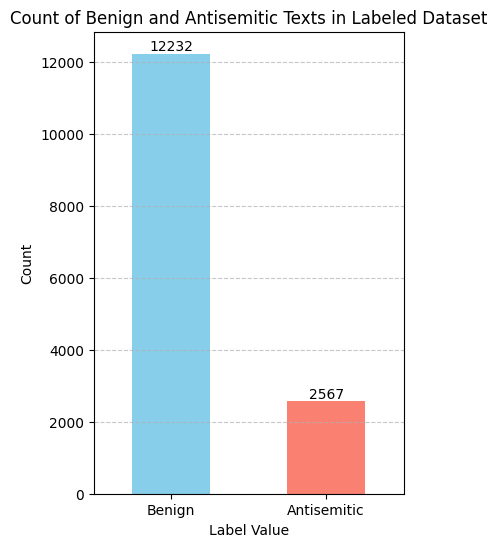

In [10]:
# Count the number of 0s and 1s in the 'Label' column
label_counts = public_df['Label'].value_counts()

# Create a bar plot
plt.figure(figsize=(4, 6))
bars = label_counts.plot(kind='bar', color=['skyblue', 'salmon'])

# Add exact counts on top of each bar
for i, count in enumerate(label_counts):
    plt.text(i, count + 0.5, str(count), ha='center', va='bottom')

plt.title('Count of Benign and Antisemitic Texts in Labeled Dataset')
plt.xlabel('Label Value')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['Benign', 'Antisemitic'], rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

It looks like the labeled datasets have a very small amount of antisemitic labeled texts compared to the amount of benign texts.

In [11]:
countBengin = label_counts.get(0, 0)
countAnti = label_counts.get(1, 0)
total = countBengin + countAnti

percentBengin = countBengin / total * 100
percentAnti = countAnti / total * 100

print(f'Benign: \t{percentBengin:.2f}%')
print(f'Antisemitic: \t{percentAnti:.2f}%')

Benign: 	82.65%
Antisemitic: 	17.35%


### Cleaning the texts and remove stop words

In [12]:
# Convert messages to lowercase and tokenize
messages = public_df['Text'].astype(str).str.lower()
all_words = ' '.join(messages).split()

# Get frequency distribution of words
word_freq = Counter(all_words)
print('Top 20 words:\n')
for word, count in word_freq.most_common(20):
    print(f'"{word}" - {count}')

Top 20 words:

"the" - 19515
"to" - 10468
"of" - 10370
"and" - 8611
"in" - 8163
"a" - 7338
"jews" - 7261
"is" - 5581
"for" - 4087
"israel" - 3956
"that" - 3548
"are" - 3481
"you" - 2717
"on" - 2694
"rt" - 2573
"not" - 2383
"they" - 2282
"was" - 2282
"this" - 2231
"with" - 2204


In [13]:
# Helper function for removing stop words form a givne text
def tokenize_remove_stopwords(text):
    words = text.lower().split()
    filtered_words = [word for word in words if word not in stop_words]
    return filtered_words

In [14]:
# Create a column with filtered words for each message (optional, for further analysis)
public_df['Text'] = public_df['Text'].astype(str).apply(tokenize_remove_stopwords)

# Count frequency of words (after removing stop words)
from collections import Counter
all_filtered_words = [word for words in public_df['Text'] for word in words]
word_freq = Counter(all_filtered_words)

print('Top 20 Words (after stop words removal):\n')
for i, (word, count) in enumerate(word_freq.most_common(20), 1):
    print(f'{i:>2}. "{word}" — {count} occurrences')

Top 20 Words (after stop words removal):

 1. "jews" — 7261 occurrences
 2. "israel" — 3956 occurrences
 3. "rt" — 2573 occurrences
 4. "&amp;" — 2014 occurrences
 5. "people" — 1365 occurrences
 6. "jewish" — 1209 occurrences
 7. "-" — 983 occurrences
 8. "us" — 899 occurrences
 9. "jews." — 869 occurrences
10. "jews," — 829 occurrences
11. "like" — 814 occurrences
12. "one" — 764 occurrences
13. "palestinian" — 638 occurrences
14. "israeli" — 637 occurrences
15. "would" — 580 occurrences
16. "??" — 575 occurrences
17. "world" — 550 occurrences
18. "israel." — 531 occurrences
19. "know" — 498 occurrences
20. "hate" — 494 occurrences


### Cleaning the special characters form the texts

In [15]:
# Helper function that counts the amound of special characters in a string
def count_special_chars(text):
    return len(re.findall(r'[^a-zA-Z0-9\s]', text))

specialCharacterCountList = public_df['Text'].astype(str).apply(count_special_chars)
print(specialCharacterCountList.describe())

count    14799.000000
mean        72.988851
std         34.216349
min          4.000000
25%         47.000000
50%         70.000000
75%         95.000000
max        443.000000
Name: Text, dtype: float64


In [16]:
# Helper function to remove special characters but keep spaces
def clean_text(text):
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    text = ' '.join(text.split())
    return text

public_df['Text'] = public_df['Text'].astype(str).apply(clean_text)

### Checking the freaquency of keywords in the texts

In [17]:
# List of possible anti-semitic words
keywords = [
    'jew', 'jews', 'jewess', 'jewish', 'israel', 'isreal', 'israhell', 'idf',
    'zionist', 'zionists', 'zionism', 'zion', 'zio', 'zioist', 'zionazi', 'mossad',
    'mosad', 'palestine', 'palestinian', 'holocaust', 'holohoax', 'hollowhoax', 'shoah', 'shoax',
    'auschwitz', 'treblinka', 'nuremberg', 'kike', 'heeb', 'yid', 'shylock', 'hooknose',
    'goy', 'goyim', 'gentile', 'gentiles', 'bloodlibel', 'zog', 'rothschild', 'circumcision',
    'talmud', 'chosen', 'synagogue', 'occupation', 'occupied'
]

In [18]:
# Helper function for counting the keywords
def count_keywords(text):
    return sum(text.lower().count(word) for word in keywords)

public_df['KeywordCount'] = public_df['Text'].astype(str).apply(count_keywords)

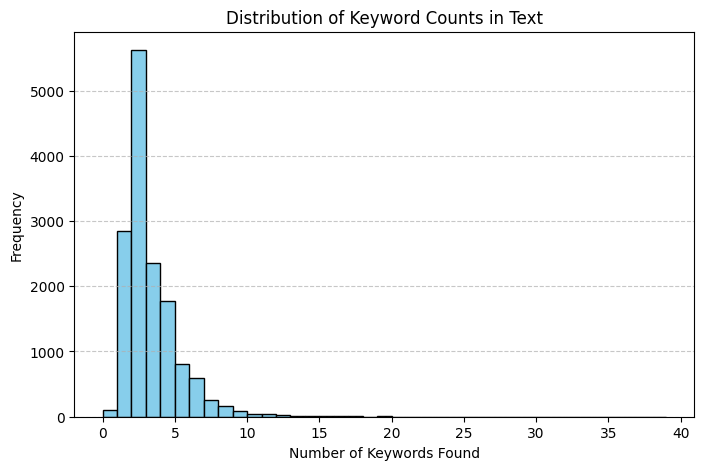

In [19]:
plt.figure(figsize=(8, 5))
plt.hist(public_df['KeywordCount'], bins=range(public_df['KeywordCount'].max()), color='skyblue', edgecolor='black')
plt.title('Distribution of Keyword Counts in Text')
plt.xlabel('Number of Keywords Found')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

The distribution reveals that most tweets contain between 1 and 5 keywords. This suggests that even benign texts often include at least one keyword. Additionally, it is evident that only a small number of tweets contain more than 10 keywords.

### Checking the distibution of text lengths

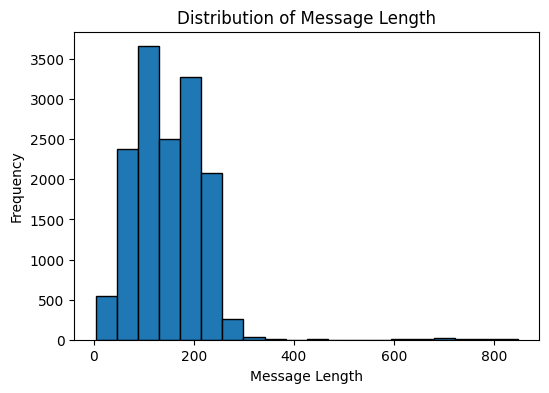

In [20]:
# Printing the distibution of text lengths
messageLengthList = public_df['Text'].apply(lambda x: len(str(x)))
plt.figure(figsize=(6, 4))
plt.hist(messageLengthList, bins=20, edgecolor='black')
plt.xlabel('Message Length')
plt.ylabel('Frequency')
plt.title('Distribution of Message Length')
plt.show()

The distribution indicates that most tweets are relatively short, primarily ranging between 1 and 250 characters. However, there is also a small number of unusually long tweets exceeding 600 characters.

### Looking at a word cloud of the words in the dataset

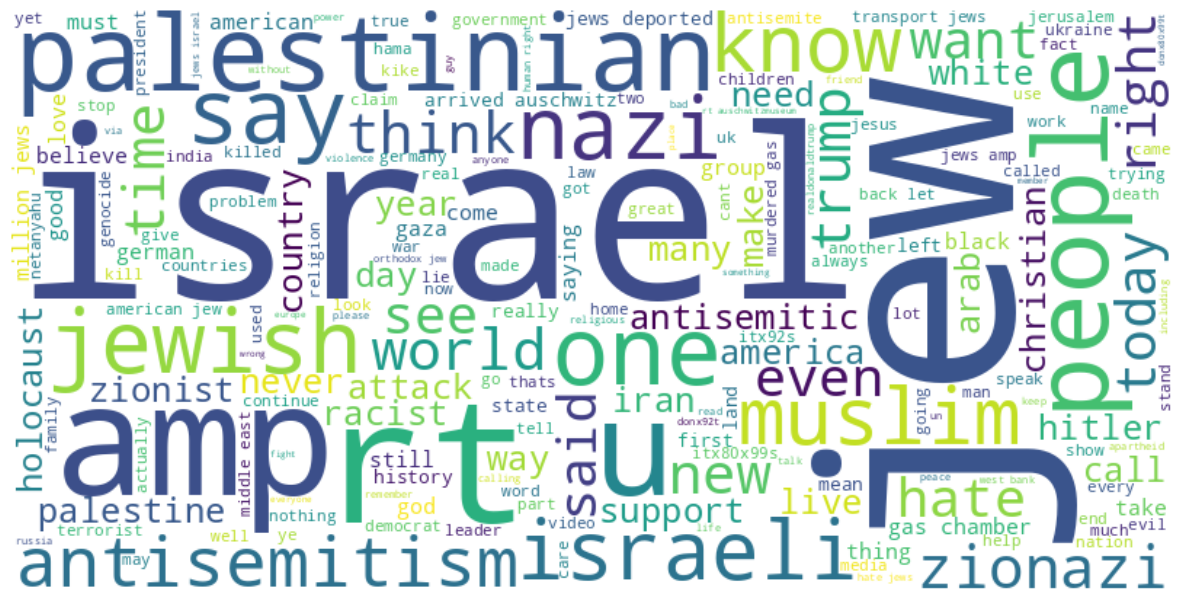

In [21]:
# Combine all messages into one large text and generate a word cloud
text = ' '.join(public_df['Text'].astype(str))
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(15, 9))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

The word cloud indicates that terms such as "Jew", "Israel", and "Palestinian" are among the most frequently occurring in the dataset, reflecting the central topics of discussion. Additionally, we observe high frequencies of irrelevant or preprocessed artifacts like "amp", "rt", and "u", which likely represent noise introduced during data scraping or tokenization.

### Performatin a simple sentiment analysis on the data

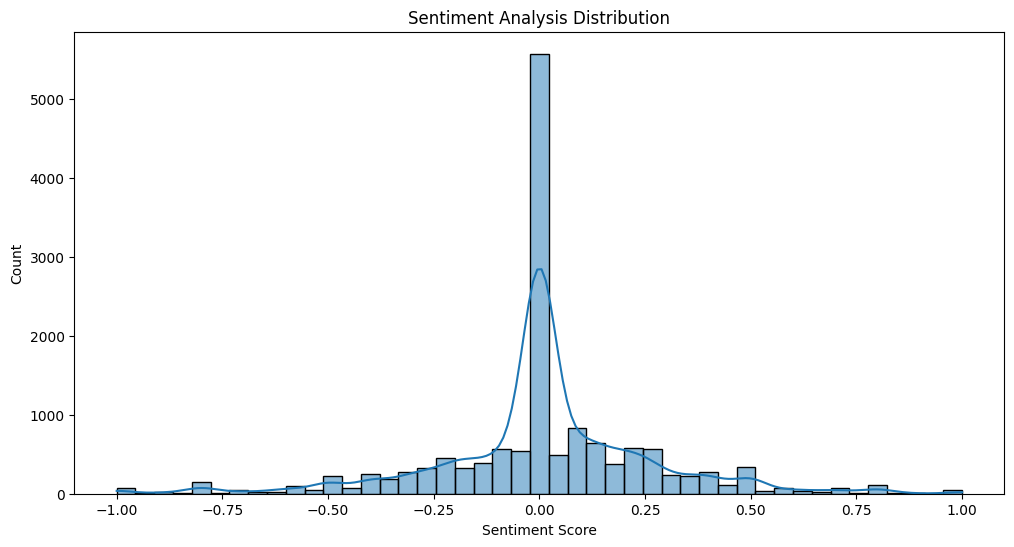

In [22]:
# Get sentiment polarity (negative < 0, neutral = 0, positive > 0)
sentimentList = public_df['Text'].astype(str).apply(lambda x: TextBlob(x).sentiment.polarity)

plt.figure(figsize=(12, 6))
sns.histplot(sentimentList, bins=45, kde=True)
plt.title('Sentiment Analysis Distribution')
plt.xlabel('Sentiment Score')
plt.ylabel('Count')
plt.show()

The sentiment analysis distribution is heavily centered around 0, indicating that most of the data has neutral sentiment. There are fewer instances of strongly positive or negative sentiment, suggesting the overall tone is generally balanced

---

## **EDA for Reddit Data**

### Loading and preparing the data

In [23]:
reddit_df = pd.read_csv('/content/reddit_collected_dataset.csv', encoding='latin1')  #this dataset has unreliable labels (data we collected from reddit)

# Rename and reorder some columns
reddit_df = reddit_df.rename(columns={'Timestamp': 'CreateDate'})
reddit_df = reddit_df[['ID', 'Username', 'CreateDate', 'Label', 'Likes', 'Text', 'Link']]

# Clean the reddit data in the same way we cleaned the labeled dataset
reddit_df['Text'] = reddit_df['Text'].astype(str).apply(tokenize_remove_stopwords)
reddit_df['Text'] = reddit_df['Text'].astype(str).apply(clean_text)

# Ensure label column exists and is numeric
reddit_df = reddit_df[reddit_df['Label'].notna()]
reddit_df['Label'] = pd.to_numeric(reddit_df['Label'], errors='coerce')
reddit_df = reddit_df.dropna(subset=['Label'])
reddit_df = reddit_df.drop_duplicates(subset='Text', keep='first') #drop duplicates
print(f'Reddit Dataset Shape: {reddit_df.shape}')

Reddit Dataset Shape: (29083, 7)


### Visualizing the class distribution

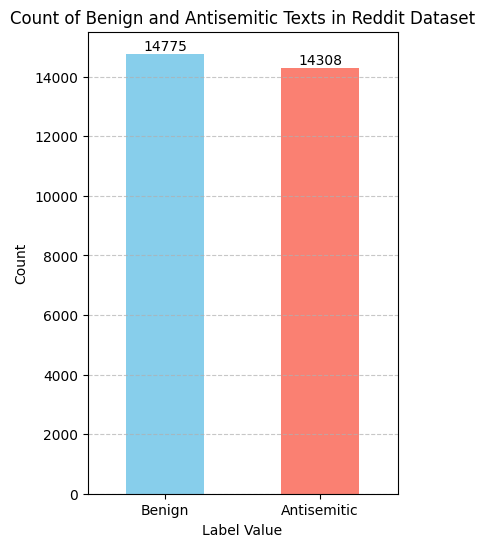

In [24]:
# Count the number of 0s and 1s in the 'Label' column
label_counts = reddit_df['Label'].value_counts()

# Create a bar plot
plt.figure(figsize=(4, 6))
bars = label_counts.plot(kind='bar', color=['skyblue', 'salmon'])

# Add exact counts on top of each bar
for i, count in enumerate(label_counts):
    plt.text(i, count + 0.5, str(count), ha='center', va='bottom')

plt.title('Count of Benign and Antisemitic Texts in Reddit Dataset')
plt.xlabel('Label Value')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['Benign', 'Antisemitic'], rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

### Removing stop words

In [25]:
# Create a column with filtered words for each message (optional, for further analysis)
reddit_df['Text'] = reddit_df['Text'].astype(str).apply(tokenize_remove_stopwords)

# Count frequency of words (after removing stop words)
from collections import Counter
all_filtered_words = [word for words in reddit_df['Text'] for word in words]
word_freq = Counter(all_filtered_words)

print('Top 20 words (after stop words removal):\n')
for word, count in word_freq.most_common(20):
    print(f'"{word}" - {count}')

Top 20 words (after stop words removal):

"israel" - 13713
"people" - 9384
"would" - 6651
"like" - 6439
"jews" - 6045
"hamas" - 5725
"palestinians" - 5327
"one" - 4794
"even" - 4527
"think" - 4479
"war" - 4445
"israeli" - 3740
"palestinian" - 3709
"jewish" - 3659
"gaza" - 3633
"also" - 3438
"state" - 3294
"want" - 3276
"us" - 3132
"land" - 3047


### Counting the number of keywords

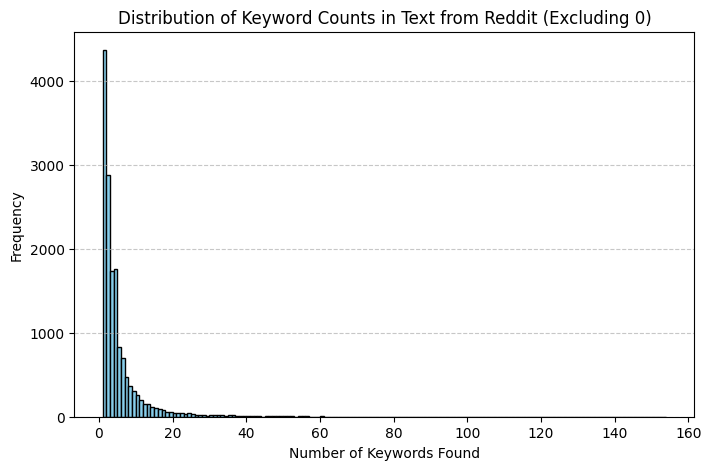

In [26]:
reddit_df['KeywordCount'] = reddit_df['Text'].astype(str).apply(count_keywords)
filtered = reddit_df[reddit_df['KeywordCount'] > 0]

plt.figure(figsize=(8, 5))
plt.hist(filtered['KeywordCount'], bins=range(1, filtered['KeywordCount'].max() + 2), color='skyblue', edgecolor='black')
plt.title('Distribution of Keyword Counts in Text from Reddit (Excluding 0)')
plt.xlabel('Number of Keywords Found')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


## **Creating a Simple Classification Model for Public (labeled) Dataset**

### **TF-IDF Data Vectorization and Normalization:**

In [27]:
# Create a TF-IDF vectorizer
vectorizer = TfidfVectorizer(max_features=2500) #limit to 2500 most important words
tfidf_matrix = vectorizer.fit_transform(public_df['Text'])

# Normalize the matrix
normalizer = Normalizer(norm='l2') #ernsures each row has unit norm
normalized_tfidf = normalizer.fit_transform(tfidf_matrix)

tfidf_df = pd.DataFrame(normalized_tfidf.toarray(), columns=vectorizer.get_feature_names_out())
print(f'TF-IDF Dataset Shape: {tfidf_df.shape}')

TF-IDF Dataset Shape: (14799, 2500)


### **Creating a Random Forest Model:**

In [28]:
# Define X and y
X = tfidf_df
y = public_df['Label']

# Split data into train and test (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Create and train a Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predict on test set
y_pred = rf_model.predict(X_test)

# Evaluate model and print confusion matrix
print('\nEvaluation Metrics:')
print(f'Accuracy:  {accuracy_score(y_test, y_pred):.4f}')
print(f'Precision: {precision_score(y_test, y_pred):.4f}')
print(f'Recall:    {recall_score(y_test, y_pred):.4f}')
print(f'F1 Score:  {f1_score(y_test, y_pred):.4f}')
print('\nConfusion Matrix:')
print(confusion_matrix(y_test, y_pred))

# Print classification report
print('\nClassification Report:')
print(classification_report(y_test, y_pred, digits=4))


Evaluation Metrics:
Accuracy:  0.9122
Precision: 0.8799
Recall:    0.5712
F1 Score:  0.6927

Confusion Matrix:
[[2407   40]
 [ 220  293]]

Classification Report:
              precision    recall  f1-score   support

           0     0.9163    0.9837    0.9488      2447
           1     0.8799    0.5712    0.6927       513

    accuracy                         0.9122      2960
   macro avg     0.8981    0.7774    0.8207      2960
weighted avg     0.9100    0.9122    0.9044      2960



Looks like the basic Random Forest model that was trained on the labeled dataset acheived good results with 91% accuracy. The issue here is that the recall is very low, at 57%, this means that the model has a hard time labeling antisemitic data with is the main task of this model.

---

## **Adding Reddit Data:**

### Lets combine the labled dataset with the dataset we collected from Reddit and we labeled our-selves in a naive way as described above, and see if the model's performance improves or not.

### **Import the Reddit Dataset and Merge the Datasets:**

In [29]:
reddit_df = pd.read_csv('/content/reddit_collected_dataset.csv', encoding='latin1')  #this dataset has unreliable labels (data we collected from reddit)

# Rename and reorder some columns
reddit_df = reddit_df.rename(columns={'Timestamp': 'CreateDate'})
reddit_df = reddit_df[['ID', 'Username', 'CreateDate', 'Label', 'Likes', 'Text', 'Link']]

# Clean the reddit data in the same way we cleaned the labeled dataset
reddit_df['Text'] = reddit_df['Text'].astype(str).apply(tokenize_remove_stopwords)
reddit_df['Text'] = reddit_df['Text'].astype(str).apply(clean_text)

# Ensure label column exists and is numeric
reddit_df = reddit_df[reddit_df['Label'].notna()]
reddit_df['Label'] = pd.to_numeric(reddit_df['Label'], errors='coerce')
reddit_df = reddit_df.dropna(subset=['Label'])
reddit_df = reddit_df.drop_duplicates(subset='Text', keep='first') #drop duplicates
print(f'Reddit Dataset Shape: {reddit_df.shape}')

# Final combined clean-up
combined_df = pd.concat([
    public_df[['Text', 'Label']],
    reddit_df[['Text', 'Label']]
], ignore_index=True)

# Make sure all labels are integers
combined_df['Label'] = combined_df['Label'].astype(int)
print(f'Combined Dataset Shape: {combined_df.shape}')

Reddit Dataset Shape: (29083, 7)
Combined Dataset Shape: (43882, 2)


## **EDA for Merged Dataset:**

### Visualizing the class distribution

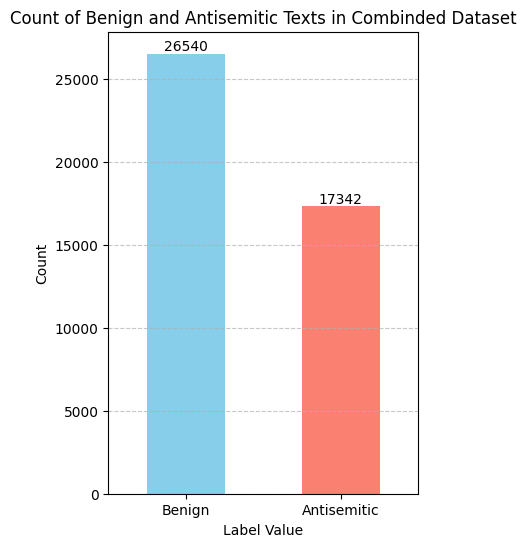

In [30]:
# Count the number of 0s and 1s in the 'Label' column
label_counts = combined_df['Label'].value_counts()

# Create a bar plot
plt.figure(figsize=(4, 6))
bars = label_counts.plot(kind='bar', color=['skyblue', 'salmon'])

# Add exact counts on top of each bar
for i, count in enumerate(label_counts):
    plt.text(i, count + 0.5, str(count), ha='center', va='bottom')

plt.title('Count of Benign and Antisemitic Texts in Combinded Dataset')
plt.xlabel('Label Value')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['Benign', 'Antisemitic'], rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

### Counting the difference in distribution between the classes

In [31]:
countBengin = label_counts.get(0, 0)
countAnti = label_counts.get(1, 0)
total = countBengin + countAnti

percentBengin = countBengin / total * 100
percentAnti = countAnti / total * 100

print(f'Benign: \t{percentBengin:.2f}%')
print(f'Antisemitic: \t{percentAnti:.2f}%')

Benign: 	60.48%
Antisemitic: 	39.52%


### Counting the average length of texts

In [32]:
avg_len_0 = combined_df[combined_df['Label'] == 0]['Text'].astype(str).apply(len).mean()
avg_len_1 = combined_df[combined_df['Label'] == 1]['Text'].astype(str).apply(len).mean()
print(f'Average length of texts labeled as benign: {int(avg_len_0)}')
print(f'Average length of texts labeled as antisemitic: {int(avg_len_1)}')

Average length of texts labeled as benign: 159
Average length of texts labeled as antisemitic: 369


### Removing stop words and printing most common words

In [35]:
# Count frequency of words (after removing stop words)
from collections import Counter
all_filtered_words = [word for text in combined_df['Text'] for word in text.split()]
word_freq = Counter(all_filtered_words)

print('Top 20 Words (after stop words removal):\n')
for i, (word, count) in enumerate(word_freq.most_common(20), 1):
    print(f'{i:>2}. "{word}" — {count} occurrences')

Top 20 Words (after stop words removal):

 1. "israel" — 19344 occurrences
 2. "jews" — 15807 occurrences
 3. "people" — 11072 occurrences
 4. "like" — 7298 occurrences
 5. "would" — 7234 occurrences
 6. "palestinians" — 5945 occurrences
 7. "hamas" — 5886 occurrences
 8. "one" — 5619 occurrences
 9. "jewish" — 4994 occurrences
10. "even" — 4959 occurrences
11. "think" — 4906 occurrences
12. "war" — 4824 occurrences
13. "us" — 4422 occurrences
14. "israeli" — 4409 occurrences
15. "palestinian" — 4392 occurrences
16. "gaza" — 3982 occurrences
17. "also" — 3908 occurrences
18. "state" — 3780 occurrences
19. "want" — 3588 occurrences
20. "right" — 3523 occurrences


In [37]:
# Function to get top words for a given label
def print_top_words_for_label(label):
    texts = combined_df[combined_df['Label'] == label]['Text']
    all_words = [word for words in texts for word in words.split()]
    word_freq = Counter(all_words)
    print(f'\nTop 20 Words for Label - {"Benign" if label == 0 else "Antisemitic"}:\n')
    for i, (word, count) in enumerate(word_freq.most_common(20), 1):
        print(f'{i:>2}. {word} — {count} occurrences')

# Print for label 0 and 1
print_top_words_for_label(0)
print_top_words_for_label(1)


Top 20 Words for Label - Benign:

 1. jews — 8701 occurrences
 2. israel — 5035 occurrences
 3. people — 4540 occurrences
 4. like — 3239 occurrences
 5. would — 2705 occurrences
 6. us — 2465 occurrences
 7. one — 2307 occurrences
 8. rt — 2219 occurrences
 9. think — 1958 occurrences
10. even — 1758 occurrences
11. get — 1721 occurrences
12. amp — 1714 occurrences
13. time — 1562 occurrences
14. know — 1463 occurrences
15. also — 1407 occurrences
16. world — 1311 occurrences
17. trump — 1288 occurrences
18. jewish — 1245 occurrences
19. want — 1234 occurrences
20. make — 1204 occurrences

Top 20 Words for Label - Antisemitic:

 1. israel — 14309 occurrences
 2. jews — 7106 occurrences
 3. people — 6532 occurrences
 4. hamas — 5527 occurrences
 5. palestinians — 5469 occurrences
 6. would — 4529 occurrences
 7. like — 4059 occurrences
 8. palestinian — 3852 occurrences
 9. israeli — 3851 occurrences
10. jewish — 3749 occurrences
11. war — 3727 occurrences
12. gaza — 3523 occurrences


### Counting the number of keywords

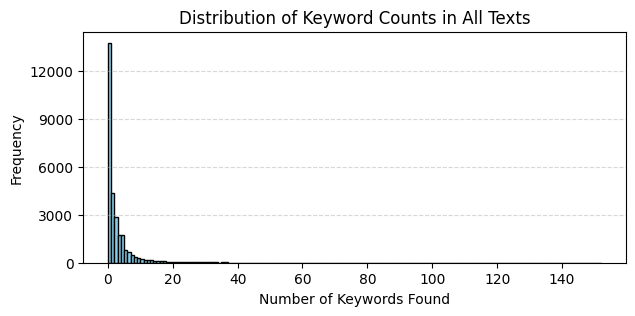

In [ ]:
reddit_df['KeywordCount'] = reddit_df['Text'].astype(str).apply(count_keywords)

plt.figure(figsize=(7, 3))
plt.hist(reddit_df['KeywordCount'], bins=range(reddit_df['KeywordCount'].max()), color='skyblue', edgecolor='black')
plt.title('Distribution of Keyword Counts in All Texts')
plt.xlabel('Number of Keywords Found')
plt.ylabel('Frequency')
y_max = plt.gca().get_ylim()[1]  # Get the maximum y value
plt.yticks(np.arange(0, y_max, step=3000))  # Adjust 'step' to change the interval
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

### Print word cloud

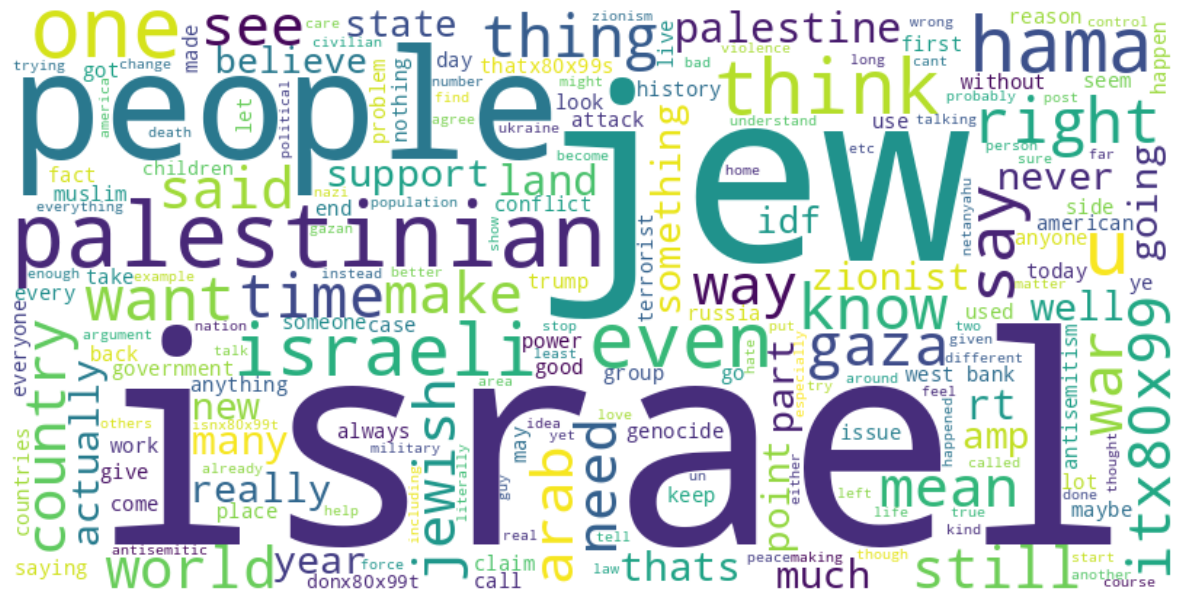

In [ ]:
# Combine all messages into one large text and generate a word cloud
text = ' '.join(combined_df['Text'].astype(str))
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(15, 9))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

## **Creating a Simple Classification Model for Merged Dataset**

### **TF-IDF Data Vectorization and Normalization:**

In [ ]:
# Create a TF-IDF vectorizer
vectorizer = TfidfVectorizer(max_features=2500) #limit to 2500 most important words
tfidf_matrix = vectorizer.fit_transform(combined_df['Text'])

# Normalize the matrix
normalizer = Normalizer(norm='l2') #ernsures each row has unit norm
normalized_tfidf = normalizer.fit_transform(tfidf_matrix)

tfidf_df = pd.DataFrame(normalized_tfidf.toarray(), columns=vectorizer.get_feature_names_out())
print(f'TF-IDF Dataset Shape: {tfidf_df.shape}')

TF-IDF Dataset Shape: (43882, 2500)


### **Creating a Random Forest Model:**

In [ ]:
# Define X and y
X = tfidf_df
y = combined_df['Label']

# Split data into train and test (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Create and train a Random Forest model
rf_model = RandomForestClassifier(n_estimators=200, random_state=42)
rf_model.fit(X_train, y_train)

# Predict on test set
y_pred = rf_model.predict(X_test)

# Evaluate model and print confusion matrix
print('\nEvaluation Metrics:')
print(f'Accuracy:  {accuracy_score(y_test, y_pred):.4f}')
print(f'Precision: {precision_score(y_test, y_pred):.4f}')
print(f'Recall:    {recall_score(y_test, y_pred):.4f}')
print(f'F1 Score:  {f1_score(y_test, y_pred):.4f}')
print('\nConfusion Matrix:')
print(confusion_matrix(y_test, y_pred))

# Print classification report
print('\nClassification Report:')
print(classification_report(y_test, y_pred, digits=4))


Evaluation Metrics:
Accuracy:  0.8985
Precision: 0.8904
Recall:    0.8475
F1 Score:  0.8684

Confusion Matrix:
[[4946  362]
 [ 529 2940]]

Classification Report:
              precision    recall  f1-score   support

           0     0.9034    0.9318    0.9174      5308
           1     0.8904    0.8475    0.8684      3469

    accuracy                         0.8985      8777
   macro avg     0.8969    0.8897    0.8929      8777
weighted avg     0.8982    0.8985    0.8980      8777



The performance of the Random Forest model remains strong, with only a slight decrease in accuracy (approximately 2%). Notably, the recall has improved significantly to 84.7%, indicating that the model was able to learn meaningful patterns—even though the Reddit data was labeled using a relatively naive approach.<br>

In [ ]:
# Saving the model, normalizer and vectorizer
joblib.dump(normalizer, '/content/bestModel/normalizer.pkl')
joblib.dump(vectorizer, '/content/bestModel/vectorizer.pkl')
joblib.dump(rf_model, '/content/bestModel/rf_model.pkl')

['/content/bestModel/rf_model.pkl']

---

## **Creating a KNN Model:**
### After combining the labeled dataset with the Reddit dataset, we were able to create a Random Forest model that has a high accuracy and recall, it might be a suitable model for classifing texts between benign and antisemitic.
### Our next steps will be to try and build a different model to see if we can get better performance.

In [ ]:
# Define X and y (using the same tfidf dataset as for the Random Forest model)
X = tfidf_df
y = combined_df['Label']

# Split data into train and test (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Create and train a K-Nearest Neighbors model
knn_model = KNeighborsClassifier(n_neighbors=5)  # You can tune n_neighbors
knn_model.fit(X_train, y_train)

# Predict on test set
y_pred = knn_model.predict(X_test)

# Evaluate model and print confusion matrix
print('\nEvaluation Metrics:')
print(f'Accuracy:  {accuracy_score(y_test, y_pred):.4f}')
print(f'Precision: {precision_score(y_test, y_pred):.4f}')
print(f'Recall:    {recall_score(y_test, y_pred):.4f}')
print(f'F1 Score:  {f1_score(y_test, y_pred):.4f}')
print('\nConfusion Matrix:')
print(confusion_matrix(y_test, y_pred))

# Print classification report
print('\nClassification Report:')
print(classification_report(y_test, y_pred, digits=4))


Evaluation Metrics:
Accuracy:  0.6249
Precision: 0.8084
Recall:    0.0669
F1 Score:  0.1235

Confusion Matrix:
[[5253   55]
 [3237  232]]

Classification Report:
              precision    recall  f1-score   support

           0     0.6187    0.9896    0.7614      5308
           1     0.8084    0.0669    0.1235      3469

    accuracy                         0.6249      8777
   macro avg     0.7135    0.5283    0.4425      8777
weighted avg     0.6937    0.6249    0.5093      8777



The KNN model peformed very poorly, we will now look at other models like SVM and Neural Networks

## **Creating SVM Model:**

In [ ]:
# Define X and y (using the same TF-IDF dataset)
X = tfidf_df
y = combined_df['Label']

# Split data into train and test (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Create and train an Linear SVM model
svm_model = LinearSVC()
svm_model.fit(X_train, y_train)

# Predict on test set
y_pred = svm_model.predict(X_test)

# Evaluate model and print confusion matrix
print('\nEvaluation Metrics:')
print(f'Accuracy:  {accuracy_score(y_test, y_pred):.4f}')
print(f'Precision: {precision_score(y_test, y_pred):.4f}')
print(f'Recall:    {recall_score(y_test, y_pred):.4f}')
print(f'F1 Score:  {f1_score(y_test, y_pred):.4f}')
print('\nConfusion Matrix:')
print(confusion_matrix(y_test, y_pred))

# Print classification report
print('\nClassification Report:')


Evaluation Metrics:
Accuracy:  0.8523
Precision: 0.8533
Recall:    0.7564
F1 Score:  0.8020

Confusion Matrix:
[[4857  451]
 [ 845 2624]]

Classification Report:


The SVM model performed good, but still the Random Forest model is a much better option due to the higher accuracy and recall. <br>
Lets try a simple Neural Network model.

## **Creating a Simple Neural Network Model:**

In [ ]:
# Define X and y (using the same tfidf dataset as for the Random Forest model)
X = tfidf_df
y = combined_df['Label'].astype(int).values

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Define a simple feedforward neural network
model = Sequential()
model.add(Dense(512, input_shape=(X.shape[1],), activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

early_stop = EarlyStopping(
    monitor='val_accuracy',
    patience=3, #stop after 3 epochs with no val_accuracy improvement
    restore_best_weights=True,
    verbose=1
)

model_checkpoint = ModelCheckpoint(
    'best_model.keras', #save the model to file
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

# Train model and evaluate the model
history = model.fit(X_train, y_train, epochs=15, batch_size=32, validation_split=0.1, callbacks=[early_stop, model_checkpoint])
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"\nNeural Network Accuracy on Test Set: {accuracy:.4f}")

# Predict and convert probabilities to binary class labels
y_pred_probs = model.predict(X_test)
y_pred = (y_pred_probs > 0.5).astype("int32").flatten()
y_true = y_test

# Evaluate model and print confusion matrix
print('\nEvaluation Metrics:')
print(f'Accuracy:  {accuracy_score(y_test, y_pred):.4f}')
print(f'Precision: {precision_score(y_test, y_pred):.4f}')
print(f'Recall:    {recall_score(y_test, y_pred):.4f}')
print(f'F1 Score:  {f1_score(y_test, y_pred):.4f}')
print('\nConfusion Matrix:')
print(confusion_matrix(y_test, y_pred))

# Print classification report
print('\nClassification Report:')
print(classification_report(y_test, y_pred, digits=4))

Epoch 1/15
987/988 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.7898 - loss: 0.4518
Epoch 1: val_accuracy improved from -inf to 0.86500, saving model to best_model.keras
988/988 ━━━━━━━━━━━━━━━━━━━━ 28s 25ms/step - accuracy: 0.7899 - loss: 0.4517 - val_accuracy: 0.8650 - val_loss: 0.3379
Epoch 2/15
988/988 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.8943 - loss: 0.2642
Epoch 2: val_accuracy improved from 0.86500 to 0.87183, saving model to best_model.keras
988/988 ━━━━━━━━━━━━━━━━━━━━ 25s 25ms/step - accuracy: 0.8943 - loss: 0.2642 - val_accuracy: 0.8718 - val_loss: 0.3251
Epoch 3/15
987/988 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9447 - loss: 0.1504
Epoch 3: val_accuracy improved from 0.87183 to 0.88095, saving model to best_model.keras
988/988 ━━━━━━━━━━━━━━━━━━━━ 40s 23ms/step - accuracy: 0.9447 - loss: 0.1504 - val_accuracy: 0.8809 - val_loss: 0.3702
Epoch 4/15
988/988 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9786 - loss: 0.0598
Epoch 4: val_accuracy improved 

The Neural Network performs as good as the Random Forest model, but it still has a lower accuracy and recall. So the Random Forest model is still the prefered model for our data with the current labels.

---

## **Building a BERT Classifier:**
### Given that no model outperformed the Random Forest classifier, the limitation may stem from the quality of the dataset itself. To address this, we plan to re-label the Reddit-sourced data using BERT similarity (Bidirectional Encoder Representations from Transformers). By computing semantic similarity between text samples in the labeled dataset, we aim to assign more accurate labels to the Reddit data.
### BERT utilizes deep contextual embeddings to capture the semantic meaning of text, enabling more precise measurement of textual similarity. This re-labeling process is expected to produce labels that better align with the content of the Reddit posts, potentially leading to improved model performance.

### **Define the BERT Similarity Classifier**

In [ ]:
# Set the device to GPU if available, otherwise use CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# BERT-based similarity classifier using sentence embeddings
class BERTSimilarityClassifier:
    def __init__(self, model_name='sentence-transformers/all-MiniLM-L6-v2'):
        # Load tokenizer and BERT model from the specified model name
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = AutoModel.from_pretrained(model_name).to(device)

        # Initialize variables to store embeddings and labels
        self.embeddings = None
        self.labels = None
        self.threshold = 0.5 #default similarity threshold

    # Method the encodes a list of texts into BERT embeddings using mean pooling
    def encode(self, texts, batch_size=32):
        self.model.eval() #set the model to evaluation mode
        all_embeddings = []

        with torch.no_grad(): #disable gradient tracking for efficiency
            for i in tqdm(range(0, len(texts), batch_size), desc='Encoding'):
                batch = texts[i:i+batch_size]

                # Tokenize and send batch to the appropriate device (CPU/GPU)
                encoded_input = self.tokenizer(batch, padding=True, truncation=True, return_tensors='pt').to(device)
                model_output = self.model(**encoded_input)

                # Get embeddings from output
                embeddings = model_output.last_hidden_state.mean(dim=1)
                all_embeddings.append(embeddings.cpu())

        # Concatenate all embeddings into one tensor and return as numpy array
        return torch.cat(all_embeddings).numpy()

    # Method that stores embeddings and corresponding labels for later similarity comparison
    def fit(self, texts, labels):
        self.embeddings = self.encode(texts)  # Encode training texts
        self.labels = np.array(labels)        # Store training labels as numpy array

    # Method that evaluates multiple similarity thresholds on validation data to find the best F1 score
    def find_optimal_threshold(self, val_texts, val_labels):
        val_embeddings = self.encode(val_texts)
        f1_scores = []
        thresholds = np.arange(0.3, 0.9, 0.05) #try thresholds from 0.3 to 0.85

        # Find optimal threshold by testing each one
        for threshold in thresholds:
            preds = []

            for emb in val_embeddings:
                # Compute cosine similarities between the current embedding and all training embeddings
                sims = cosine_similarity([emb], self.embeddings)[0]

                # Get the index and score of the most similar training sample
                max_sim_index = np.argmax(sims)
                sim_score = sims[max_sim_index]

                # Assign label based on whether similarity exceeds the current threshold
                predicted_label = self.labels[max_sim_index] if sim_score >= threshold else 0
                preds.append(predicted_label)

            # Calculate F1 score for current threshold
            score = f1_score(val_labels, preds)
            f1_scores.append(score)

        # Select threshold with the highest F1 score
        best_idx = np.argmax(f1_scores)
        self.threshold = thresholds[best_idx]
        print(f'Optimal threshold: {self.threshold:.3f} (F1: {f1_scores[best_idx]:.4f})')

    # Method that predicts labels for new texts based on similarity to training samples
    def predict(self, texts):
        embeddings = self.encode(texts)
        predictions = []
        similarities = []

        for emb in embeddings:
            # Calculate cosine similarities with stored training embeddings
            sims = cosine_similarity([emb], self.embeddings)[0]

            # Identify most similar training example
            max_sim_index = np.argmax(sims)
            sim_score = sims[max_sim_index]
            similarities.append(sim_score)

            # Predict label if similarity passes threshold, else assign 0
            predicted_label = self.labels[max_sim_index] if sim_score >= self.threshold else 0
            predictions.append(predicted_label)

        return predictions, similarities

### **Use BERT to Re-Label the Reddit Dataset and Calculate Optimal Threshold Value:**

In [ ]:
# Train BERT on the labeled dataset
classifier = BERTSimilarityClassifier()
classifier.fit(public_df['Text'].tolist(), public_df['Label'].astype(int).tolist())

# Split labeled data to find optimal threshold
X_train, X_val, y_train, y_val = train_test_split(
    public_df['Text'].tolist(), public_df['Label'].astype(int).tolist(),
    test_size=0.2, random_state=42, stratify=public_df['Label']
)
classifier.find_optimal_threshold(X_val, y_val)

# Label the Reddit dataset using the BERT classifier
predicted_labels, similarity_scores = classifier.predict(reddit_df['Text'].tolist())
reddit_df['Label'] = predicted_labels
reddit_df['Similarity'] = similarity_scores

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Encoding: 100%|██████████| 93/93 [02:38<00:00,  1.70s/it]


Optimal threshold: 0.700 (F1: 0.9785)


Encoding: 100%|██████████| 909/909 [1:28:07<00:00,  5.82s/it]


### **Creating a New Random Forest Model Based on New Labels:**
### Now the Reddit dataset has new labels based on the BERT Classifier, so again we will combin the labeled dataset and the Reddit dataset, calculate TD-IDF and build a Random Forest model and see how it compares to the previous model.

In [ ]:
# Combine the two datasets
combined_df = pd.concat([
    public_df[['Text', 'Label']],
    reddit_df[['Text', 'Label']]
], ignore_index=True)

# Create a TF-IDF vectorizer
vectorizer = TfidfVectorizer(max_features=2500) #limit to 2500 most important words
tfidf_matrix = vectorizer.fit_transform(combined_df['Text'])

# Normalize the matrix
normalizer = Normalizer(norm='l2') #ernsures each row has unit norm
normalized_tfidf = normalizer.fit_transform(tfidf_matrix)

tfidf_df = pd.DataFrame(normalized_tfidf.toarray(), columns=vectorizer.get_feature_names_out())
print(f'TF-IDF Dataset Shape: {tfidf_df.shape}')

TF-IDF Dataset Shape: (43882, 2500)


In [ ]:
# Define X and y
X = tfidf_df
y = combined_df['Label'].astype(int).values

# Split data into train and test (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Create and train a Random Forest model
rf_model = RandomForestClassifier(n_estimators=200, random_state=42)
rf_model.fit(X_train, y_train)

# Predict on test set
y_pred = rf_model.predict(X_test)

# Evaluate model and print confusion matrix
print('\nEvaluation Metrics:')
print(f'Accuracy:  {accuracy_score(y_test, y_pred):.4f}')
print(f'Precision: {precision_score(y_test, y_pred):.4f}')
print(f'Recall:    {recall_score(y_test, y_pred):.4f}')
print(f'F1 Score:  {f1_score(y_test, y_pred):.4f}')
print('\nConfusion Matrix:')
print(confusion_matrix(y_test, y_pred))

# Print classification report
print('\nClassification Report:')
print(classification_report(y_test, y_pred, digits=4))


Evaluation Metrics:
Accuracy:  0.8245
Precision: 0.7792
Recall:    0.1709
F1 Score:  0.2804

Confusion Matrix:
[[6937   85]
 [1455  300]]

Classification Report:
              precision    recall  f1-score   support

           0     0.8266    0.9879    0.9001      7022
           1     0.7792    0.1709    0.2804      1755

    accuracy                         0.8245      8777
   macro avg     0.8029    0.5794    0.5902      8777
weighted avg     0.8171    0.8245    0.7762      8777



After re-labeling the Reddit dataset using the BERT similarity-based classifier, the performance of the Random Forest model declined significantly across all evaluation metrics, including accuracy, precision, recall, and F1-score. This suggests that the new labels generated through semantic similarity did not align well with the underlying structure of the data, potentially introducing noise or inconsistencies. As a result, the re-labeled dataset has hindered the model's ability to generalize and learn meaningful patterns. These findings indicate that the BERT-based labeling approach, while theoretically promising, did not translate into better performance in this specific context.

---

### **Testing a Few Other Models:**
### Here we will test a few other models to see how they perform with the new labels to try to find the best model. Using the same train/test split as before.

### XGBoost Model:

In [ ]:
# Create and train the XGBoost model
xgb_model = xgb.XGBClassifier(
    n_estimators=100, #number of boosting rounds
    learning_rate=0.1, #step size
    max_depth=6, #maximum tree depth
    random_state=42,
    use_label_encoder=False, #prevent warnings
    eval_metric='logloss'
)
xgb_model.fit(X_train, y_train)

# Predict on the test set
y_pred = xgb_model.predict(X_test)

# Evaluate the model
print('\nEvaluation Metrics:')
print(f'Accuracy:  {accuracy_score(y_test, y_pred):.4f}')
print(f'Precision: {precision_score(y_test, y_pred):.4f}')
print(f'Recall:    {recall_score(y_test, y_pred):.4f}')
print(f'F1 Score:  {f1_score(y_test, y_pred):.4f}')
print('\nConfusion Matrix:')
print(confusion_matrix(y_test, y_pred))

print('\nClassification Report:')
print(classification_report(y_test, y_pred, digits=4))


Evaluation Metrics:
Accuracy:  0.8185
Precision: 0.8240
Recall:    0.1174
F1 Score:  0.2055

Confusion Matrix:
[[6978   44]
 [1549  206]]

Classification Report:
              precision    recall  f1-score   support

           0     0.8183    0.9937    0.8975      7022
           1     0.8240    0.1174    0.2055      1755

    accuracy                         0.8185      8777
   macro avg     0.8212    0.5556    0.5515      8777
weighted avg     0.8195    0.8185    0.7592      8777



When evaluating alternative models to Random Forest, we observed that the XGBoost model performed even worse, yielding lower scores across all key metrics. This further reinforces the notion that the data, rather than the model choice, may be the limiting factor in achieving higher predictive performance.

### Simple Neural Network:

In [ ]:
# Define a simple feedforward neural network
model = Sequential()
model.add(Dense(512, input_shape=(X.shape[1],), activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

early_stop = EarlyStopping(
    monitor='val_accuracy',
    patience=3, #stop after 3 epochs with no val_accuracy improvement
    restore_best_weights=True,
    verbose=1
)

model_checkpoint = ModelCheckpoint(
    'best_model.keras', #save the model to file
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

# Train model and evaluate the model
history = model.fit(X_train, y_train, epochs=15, batch_size=32, validation_split=0.1, callbacks=[early_stop, model_checkpoint])
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"\nNeural Network Accuracy on Test Set: {accuracy:.4f}")

# Predict and convert probabilities to binary class labels
y_pred_probs = model.predict(X_test)
y_pred = (y_pred_probs > 0.5).astype("int32").flatten()
y_true = y_test

# Evaluate model and print confusion matrix
print('\nEvaluation Metrics:')
print(f'Accuracy:  {accuracy_score(y_test, y_pred):.4f}')
print(f'Precision: {precision_score(y_test, y_pred):.4f}')
print(f'Recall:    {recall_score(y_test, y_pred):.4f}')
print(f'F1 Score:  {f1_score(y_test, y_pred):.4f}')
print('\nConfusion Matrix:')
print(confusion_matrix(y_test, y_pred))

# Print classification report
print('\nClassification Report:')
print(classification_report(y_test, y_pred, digits=4))

Epoch 1/15
987/988 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8016 - loss: 0.4972
Epoch 1: val_accuracy improved from -inf to 0.82199, saving model to best_model.keras
988/988 ━━━━━━━━━━━━━━━━━━━━ 26s 24ms/step - accuracy: 0.8016 - loss: 0.4971 - val_accuracy: 0.8220 - val_loss: 0.4475
Epoch 2/15
987/988 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8171 - loss: 0.4280
Epoch 2: val_accuracy did not improve from 0.82199
988/988 ━━━━━━━━━━━━━━━━━━━━ 41s 23ms/step - accuracy: 0.8171 - loss: 0.4280 - val_accuracy: 0.8208 - val_loss: 0.4403
Epoch 3/15
986/988 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8589 - loss: 0.3284
Epoch 3: val_accuracy did not improve from 0.82199
988/988 ━━━━━━━━━━━━━━━━━━━━ 23s 23ms/step - accuracy: 0.8589 - loss: 0.3284 - val_accuracy: 0.8112 - val_loss: 0.5204
Epoch 4/15
988/988 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9464 - loss: 0.1415
Epoch 4: val_accuracy did not improve from 0.82199
988/988 ━━━━━━━━━━━━━━━━━━━━ 22s 22ms/step - accuracy: 0

Similar to the XGBoost model, the Simple Neural Network demonstrated poor performance across all evaluation metrics.

### Random Forest with Bi-Grams:

In [ ]:
# TF-IDF with unigrams + bigrams
vectorizer = TfidfVectorizer(max_features=2500, ngram_range=(1, 2))
tfidf_matrix = vectorizer.fit_transform(combined_df['Text'])

# Normalize the matrix
normalizer = Normalizer(norm='l2') #ernsures each row has unit norm
normalized_tfidf = normalizer.fit_transform(tfidf_matrix)

tfidf_df = pd.DataFrame(normalized_tfidf.toarray(), columns=vectorizer.get_feature_names_out())
print(f'TF-IDF Dataset Shape: {tfidf_df.shape}')

# Define X and y
X = tfidf_df
y = combined_df['Label']

# Split data into train and test (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Create the Random Forest model and predit the data
rf_model = RandomForestClassifier(n_estimators=200, random_state=42)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

# Evaluate model and print confusion matrix
print('\nEvaluation Metrics:')
print(f'Accuracy:  {accuracy_score(y_test, y_pred):.4f}')
print(f'Precision: {precision_score(y_test, y_pred):.4f}')
print(f'Recall:    {recall_score(y_test, y_pred):.4f}')
print(f'F1 Score:  {f1_score(y_test, y_pred):.4f}')
print('\nConfusion Matrix:')
print(confusion_matrix(y_test, y_pred))

# Print classification report
print('\nClassification Report:')
print(classification_report(y_test, y_pred, digits=4))

TF-IDF Dataset Shape: (43882, 2500)

Evaluation Metrics:
Accuracy:  0.8237
Precision: 0.7653
Recall:    0.1709
F1 Score:  0.2795

Confusion Matrix:
[[6930   92]
 [1455  300]]

Classification Report:
              precision    recall  f1-score   support

           0     0.8265    0.9869    0.8996      7022
           1     0.7653    0.1709    0.2795      1755

    accuracy                         0.8237      8777
   macro avg     0.7959    0.5789    0.5895      8777
weighted avg     0.8142    0.8237    0.7756      8777



Even after training a Random Forest model using bi-gram features, the performance remained poor.

---

# **Classification Conclusions:**
### This research aimed to build a model for detecting antisemitic texts. The Random Forest model performed best overall, achieving 91% accuracy but low recall (57%) on the initial labeled dataset. Adding a custom Reddit dataset—labeled using a simple keyword-based approach—significantly improved recall to 84.7%, showing that even naively labeled data can be useful.
### Other models like KNN, SVM, and a Neural Network were tested but failed to outperform the Random Forest model. Attempts to improve label quality using a BERT-based similarity classifier actually led to worse performance across all metrics, likely due to mislabeled or noisy data.
### In the end, even a simple but consistent labeling approach turned out to be more effective than more complex re-labeling methods. Among all the models tested, the Random Forest remained the most reliable and accurate option for this task.

---

# **Testing the Best Model:**
### Writing a function that can be used to classify a single scentence at a time to see how the model performs on different texts.

In [ ]:
# Load the best model, vectorizer and normalizer
normalizer = joblib.load('/content/bestModel/normalizer.pkl')
vectorizer = joblib.load('/content/bestModel/vectorizer.pkl')
model = joblib.load('/content/bestModel/rf_model.pkl')

# Define a function to classify a given text
def classify_text(input_text, model, vectorizer, normalizer):
    # Clean the text
    input_text = tokenize_remove_stopwords(input_text)
    input_text = " ".join(input_text)
    input_text = clean_text(input_text)

    # Vectorize and normalize the input text
    X = vectorizer.transform([input_text])
    X = normalizer.transform(X)

    # Predict the label
    prediction = model.predict(X)[0]

    # Print the output and return the prediction
    label_str = 'Benign (0)' if prediction == 0 else 'Antisemitic (1)'
    print(f'Input: {input_text}')
    print(f'Predicted Label: {label_str}')
    return prediction

### Testing on a few benign texts:

In [ ]:
benign_inputs = [
    'The weather today is sunny with a light breeze. Perfect day for a walk in the park!',
    'Orcas are very intelligent and can tell the differences between animals. They tend to go after prey that offers a high-fat, high-calorie payoff. Animals like seals, sea lions, and even other whales',
    'I just finished reading a fascinating book about space exploration and the future of technology.'
]

for input in benign_inputs:
    classify_text(input, model, vectorizer, normalizer)
    print()

Input: weather today sunny light breeze perfect day walk park
Predicted Label: Benign (0)

Input: orcas intelligent tell differences animals tend go prey offers highfat highcalorie payoff animals like seals sea lions even whales
Predicted Label: Benign (0)

Input: finished reading fascinating book space exploration future technology
Predicted Label: Benign (0)



### Testing on a few antisemitic texts:

In [ ]:
antisemitic_inputs = [
    'Right-wing and far-right movements and political parties across the world also idolise Israel as they view the Zionist colonial project as a successful model of European domination over the indigenous populations of developing countries.',
    'Israel has been destroying Palestinians and stealing their land for DECADES. The USA is drilling oil in PALESTINE, thats theft! They are INVADING another country!',
    'Despite coronavirus-caused cutbacks, Israel expects to get full $3.8 billion while thousands of Americans out of work, tens of millions impacted by coronavirus cutbacks, experts expect Israel will get its full massive aid package.'
]

for input in antisemitic_inputs:
    classify_text(input, model, vectorizer, normalizer)
    print()

Input: rightwing farright movements political parties across world also idolise israel view zionist colonial project successful model european domination indigenous populations developing countries
Predicted Label: Antisemitic (1)

Input: israel destroying palestinians stealing land decades usa drilling oil palestine thats theft invading another country
Predicted Label: Benign (0)

Input: despite coronaviruscaused cutbacks israel expects get full 38 billion thousands americans work tens millions impacted coronavirus cutbacks experts expect israel get full massive aid package
Predicted Label: Antisemitic (1)



### While not all antisemitic examples are classified correctly, the model demonstrates solid performance with an accuracy of 89% and a recall of 84% for antisemitic texts. These results indicate that the model is effective and capable of identifying most relevant instances.

---
# ***The End***